# Dataloading
In this notebook you can see how the plug-in country support works.

The three most important points are:
1. importing a country-specific data loader
2. downloading latest data
3. applying extrapolation & outlier correction

The `DataFrame` resulting from the aforementioned steps is suitable as the input to the Rtlive model.

In [1]:
# this cell makes it easier to mess with the project code interactively
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import logging
import numpy
import pandas
import pathlib
import matplotlib
from matplotlib import pyplot, cm

import arviz
import pymc3

_log = logging.getLogger('notebook')
logging.basicConfig(level=logging.INFO)

# messing with the path to get imports working
import sys
sys.path.append(str(pathlib.Path("..").resolve()))

import rtlive
from rtlive import data, preprocessing

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


## 1. Registering country support
After importing `rtlive.data`, no country loader is registered by default.

Countries are added by importing their respective `data_xy` submodules from `rtlive.sources`.

To register a country, the `data_xy` submodule should call `rtlive.data.set_country_support`. This function takes the data loading and preprocessing callables, alongside metadata about the names and population of regions within the country.
In the code, regions are identified by a code. These codes can be numeric (e.g. in DE or US) or numeric (e.g. in FR).

In [3]:
help(data.set_country_support)

Help on function set_country_support in module rtlive.data:

set_country_support(country_alpha2: str, *, compute_zone: rtlive.data.Zone, region_name: Dict[str, str], region_short_name: Union[Dict[str, str], NoneType] = None, region_population: Dict[str, int], fn_load: Callable[[pandas._libs.tslibs.timestamps.Timestamp], pandas.core.frame.DataFrame], fn_process: Callable[[pandas.core.frame.DataFrame], Tuple[pandas.core.frame.DataFrame, Dict[str, Tuple[pandas.core.series.Series, fbprophet.forecaster.Prophet, pandas.core.frame.DataFrame, Dict[datetime.datetime, str]]]]])
    Function to set support for a country.
    
    Parameters
    ----------
    country_alpha2 : str
        ISO-3166 alpha-2 short code of the country (key in SUPPORTED_COUNTRIES dict)
    compute_zone : Zone
        used to group countries by timezone for automated computing
    region_name : dict
        dictionary of { region_code : str }
        to map machine-readable region codes to human-readable names
    regio

In [7]:
# import of the country submodule adds data loading/preprocessing support
from rtlive.sources import data_be

The data is downloaded & processed based on a ISO-3166 alpha 2 two letter country code and a `datetime`.

The `run_date` is important to make historic predictions *as they would have been made* at the time.

In this example, we run for Switzerland with the latest data.

In [8]:
country_alpha2 = 'BE'
run_date = datetime.datetime.today()
run_date_str = run_date.strftime('%Y-%m-%d')
print(f"Running for {country_alpha2} on {run_date_str}")

Running for BE on 2020-11-15


In [9]:
# first download the data
df_raw = data.get_data(country_alpha2, run_date=run_date)
df_raw.tail(n=14)

/srv/conda/envs/notebook/lib/python3.7/site-packages/urllib3/connectionpool.py:988: InsecureRequestWarning: Unverified HTTPS request is being made to host 'epistat.sciensano.be'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


new_cases  new_tests
region date                            
all    2020-11-01       6397      24149
       2020-11-02       7286      28921
       2020-11-03      14884      54829
       2020-11-04      11442      44919
       2020-11-05      10139      45683
       2020-11-06       7753      39342
       2020-11-07       7013      32346
       2020-11-08       2788      13290
       2020-11-09       4518      22273
       2020-11-10       8199      38762
       2020-11-11       6094      31503
       2020-11-12       5054      27767
       2020-11-13       6685      36377
       2020-11-14        225       1934

In [18]:
df_raw.index.is_unique

True

In [19]:
df_raw.index.get_level_values(0).unique()

Index(['ANT', 'WBR', 'BRU', 'FLA', 'HAI', 'LIM', 'LIE', 'LUX', 'NAM', 'EFL',
       'FBR', 'WAL', 'WFL', 'all'],
      dtype='object', name='region')

As you can see from the dataframe above, the latest data for Switzerland does not yet include testcounts for the lastest dates.
For many countries, these gaps can be multiple weeks long and even in the middle of the data.
Furthermore, some countries have artifacts in their test count data that are obviously unrealistic (e.g. new_tests < new_cases).

These __gaps and artifacts must be dealt with in a country-specific way__ before we can use the data for modeling.

This is why the `data.set_country_support` function also took a `fn_process` callable. This way, country-specific implementations in `data_xy` can provide interpolation/extrapolation/cleaning routines while a generic country support is maintained.

To apply data cleaning to the raw data (from above), we use the `data.process_testcounts` function:

In [10]:
df_processed, forecasting_results = data.process_testcounts(
    country=country_alpha2,
    df_raw=df_raw,
)

INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for ANT from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for WBR from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for BRU from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for FLA from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for HAI from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for LIM from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for LIE from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for LUX from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for NAM from 259 training points.
INFO:/home/jovyan/rtlive/preprocessing.py:Forecasting testcount gaps for 

In [11]:
df_processed.tail(n=14)

new_cases new_tests  predicted_new_tests
region date                                               
all    2020-11-01      6397     24149              24149.0
       2020-11-02      7286     28921              28921.0
       2020-11-03     14884     54829              54829.0
       2020-11-04     11442     44919              44919.0
       2020-11-05     10139     45683              45683.0
       2020-11-06      7753     39342              39342.0
       2020-11-07      7013     32346              32346.0
       2020-11-08      2788     13290              13290.0
       2020-11-09      4518     22273              22273.0
       2020-11-10      8199     38762              38762.0
       2020-11-11      6094     31503              31503.0
       2020-11-12      5054     27767              27767.0
       2020-11-13      6685     36377              36377.0
       2020-11-14       225      1934               1934.0

The dataframe returned by `data.process_testcounts` contains a new column "predicted_new_tests", so now we have all the data we need for the model.

The second return value `forecasting_results` is a dictionary that contains detailed information about the Prophet-based testcount forecasting for every region:

In [12]:
print(f"Supported regions are: {set(forecasting_results.keys())}")

Supported regions are: {'LIM', 'EFL', 'all', 'WFL', 'HAI', 'BRU', 'FLA', 'FBR', 'WAL', 'ANT', 'LIE', 'WBR', 'LUX', 'NAM'}


In [13]:
region = "all"
for v, value in enumerate(forecasting_results[region]):
    t = type(value)
    mro = " <- ".join([c.__name__ for c in t.__mro__])
    print(f"Entry {v} is of type {t}\n  {mro}")

Entry 0 is of type <class 'pandas.core.series.Series'>
  Series <- IndexOpsMixin <- NDFrame <- PandasObject <- DirNamesMixin <- SelectionMixin <- IndexingMixin <- object
Entry 1 is of type <class 'fbprophet.forecaster.Prophet'>
  Prophet <- object
Entry 2 is of type <class 'pandas.core.frame.DataFrame'>
  DataFrame <- NDFrame <- PandasObject <- DirNamesMixin <- SelectionMixin <- IndexingMixin <- object
Entry 3 is of type <class 'holidays.countries.belgium.BEL'>
  BEL <- Belgium <- HolidayBase <- dict <- object


The `rtlive.plotting` module contains helper functions for plotting testcount forecast information:

In [14]:
from rtlive import plotting

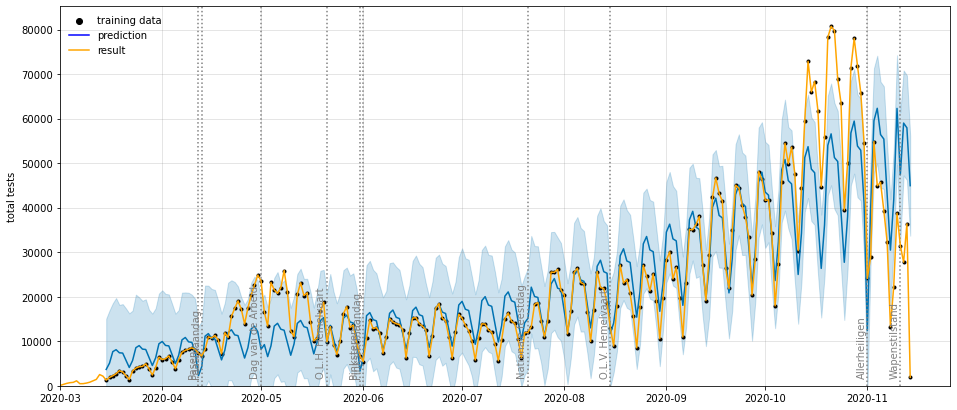

In [15]:
_, m, forecast, considered_holidays = forecasting_results[region]

axs = plotting.plot_testcount_forecast(
    df_processed.xs(region).predicted_new_tests,
    m, forecast, considered_holidays
)
pyplot.show()

/srv/conda/envs/notebook/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/srv/conda/envs/notebook/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


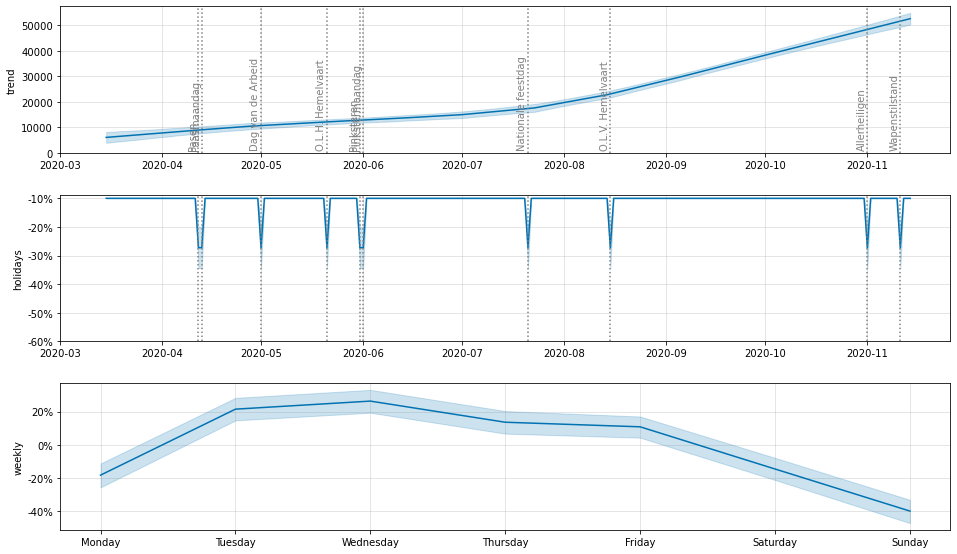

In [16]:
plotting.plot_testcount_components(m, forecast, considered_holidays);

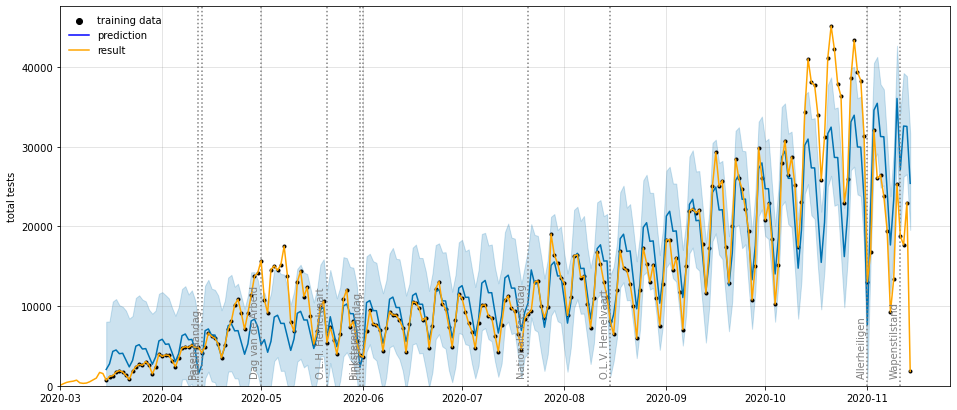

In [20]:
region = 'FLA'
_, m, forecast, considered_holidays = forecasting_results[region]

axs = plotting.plot_testcount_forecast(
    df_processed.xs(region).predicted_new_tests,
    m, forecast, considered_holidays
)
pyplot.show()

/srv/conda/envs/notebook/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/srv/conda/envs/notebook/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


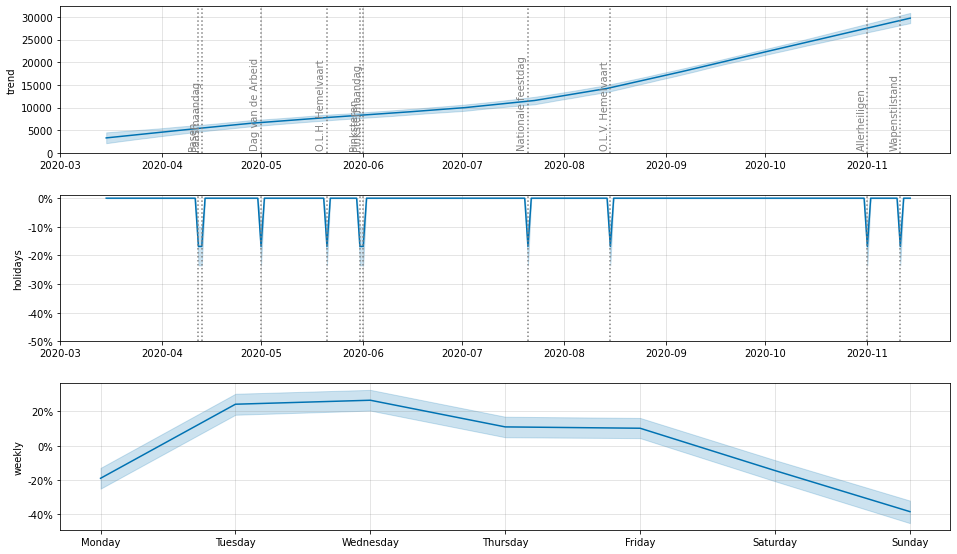

In [21]:
plotting.plot_testcount_components(m, forecast, considered_holidays);

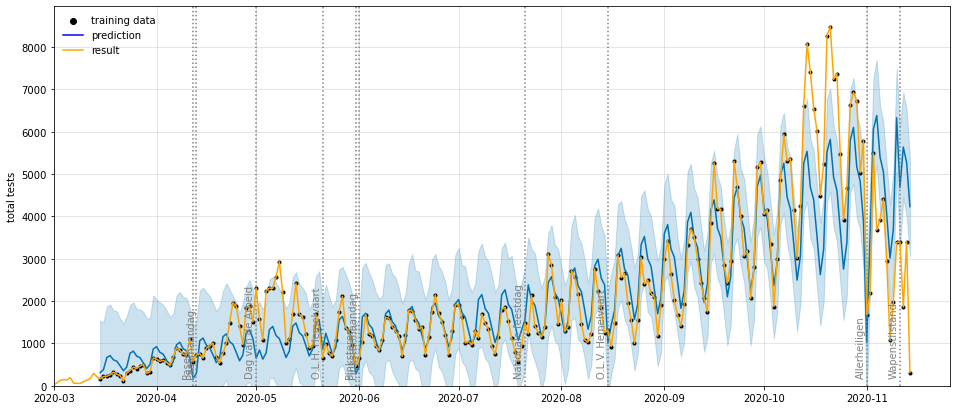

In [22]:
region = 'FBR'
_, m, forecast, considered_holidays = forecasting_results[region]

axs = plotting.plot_testcount_forecast(
    df_processed.xs(region).predicted_new_tests,
    m, forecast, considered_holidays
)
pyplot.show()

In [23]:
pandas.__version__

'1.1.4'